In [1]:
# %pip install pandas
# %pip install gpxpy
# %pip install tqdm
# %pip install matplotlib
# %pip install seaborn

In [2]:
import pandas as pd
import numpy as np

import gpxpy
import gpxpy.gpx

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

plt.style.use('ggplot')

from tqdm.auto import tqdm

import importlib
from NaivePointsGraph import NaivePointsGraph


In [3]:
def read_gpx(path):
    points = []
    with open(path, 'r') as file:
        gpx = gpxpy.parse(file)
        for track in gpx.tracks:
            for segment in track.segments:
                for point in segment.points:
                    points += [(point.longitude, point.latitude, point.elevation, point.time)]
    return points


In [4]:
points_arr = read_gpx('data.gpx')
df = pd.DataFrame(points_arr, columns=['Longitude', 'Latitude', 'Elevation', 'Time'])
df.head()

,Longitude,Latitude,Elevation,Time
0,18.930414,50.261980,269.81924,2023-08-03 21:54:13+00:00
1,18.930359,50.261950,269.91916,2023-08-03 21:54:14+00:00
2,18.930320,50.261940,269.91900,2023-08-03 21:54:15+00:00
3,18.930283,50.261932,270.01892,2023-08-03 21:54:16+00:00
4,18.930260,50.261936,270.01883,2023-08-03 21:54:17+00:00


<Axes: xlabel='Longitude', ylabel='Latitude'>

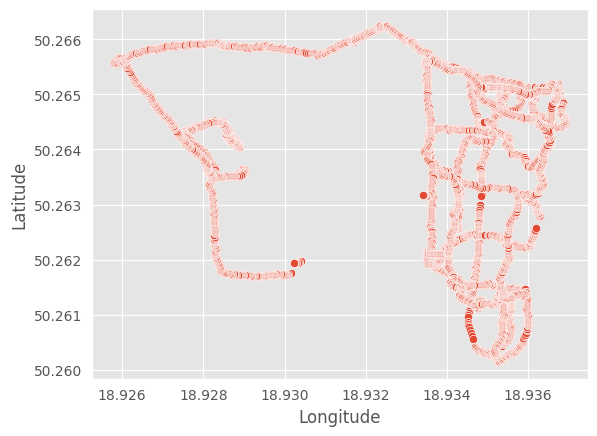

In [5]:
sns.scatterplot(x='Longitude', y='Latitude', data=df)

In [6]:
pg = NaivePointsGraph(20)
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    pg.insert_vertex(row['Longitude'], row['Latitude'])
vx, vy = pg.list_vertices()

last_long, last_lat = None, None
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    long, lat = row['Longitude'], row['Latitude']
    if last_long is not None:
        pg.insert_edge(last_long, last_lat, long, lat)
    last_long, last_lat = long, lat

last_long, last_lat = None, None
og_route = []
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    long, lat = row['Longitude'], row['Latitude']
    if last_long is not None:
        og_route += [(last_long, last_lat, long, lat)]
    last_long, last_lat = long, lat

  0%|          | 0/4991 [00:00<?, ?it/s]

  0%|          | 0/4991 [00:00<?, ?it/s]

  0%|          | 0/4991 [00:00<?, ?it/s]

In [7]:
for vi in range(pg.size()):
    v = pg.get_vertex(vi)
    if len(pg.get_edges(vi)) != 2:
        continue
    ui1, ui2 = pg.get_edges(vi)
    u1, u2 = pg.get_vertex(ui1), pg.get_vertex(ui2)
    a1, a2 = pg.azimuth(*u1, *v), pg.azimuth(*v, *u2)
    if a1 - np.pi / 20 <= a2 <= a1 + np.pi / 20:
        pg.remove_edge(vi, ui1)
        pg.remove_edge(vi, ui2)
        pg.remove_vertex(vi)
        pg.insert_edge_i(ui1, ui2)


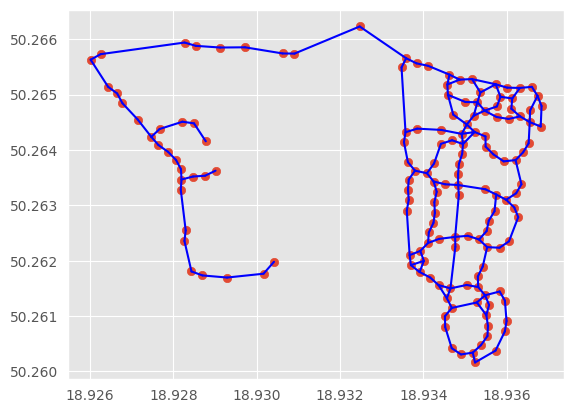

In [8]:
vx, vy = pg.list_vertices()
plt.scatter(vx, vy)

for x1, y1, x2, y2 in pg.list_edges():
    plt.plot([x1, x2], [y1, y2], c='blue')

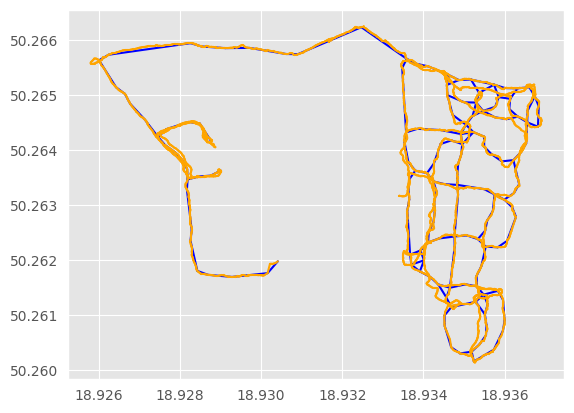

In [9]:
for x1, y1, x2, y2 in pg.list_edges():
    plt.plot([x1, x2], [y1, y2], c='blue')

for x1, y1, x2, y2 in og_route:
    plt.plot([x1, x2], [y1, y2], c='orange')